In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch 
from argparse import Namespace
from tqdm import tqdm
import pickle 
import glob 
import pydicom 

# Add the path to the directory containing the sybil module
sys.path.append('/workspace/home/tengyuezhang/sybil_cect/code/Sybil/')
from sybil.utils.metrics import concordance_index, get_survival_metrics
from sybil import Sybil, Serie
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [21]:
dataset_name = 'MLN-SEG'
# load data
risk_score_csv_path = '/workspace/home/tengyuezhang/sybil_cect/results/MLN-SEG/MLN_SEG_risk_scores.csv'
df = pd.read_csv(risk_score_csv_path)
# rename 'LungCancer' column to 'event'
df = df.rename(columns={'LungCancer': 'event'})
# proportion of positive samples 
mln_seg_percent_positive = (df['event'].sum() / len(df)) 
print(mln_seg_percent_positive)

0.28865979381443296


In [22]:
# load checkpoint (to get censor distribution on training set that is used to calculate c-index)
model = Sybil("sybil_ensemble")

/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tengyuezhang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# get y label for each year 
max_followup = 1

def calculate_y_seq(event, time_to_event, max_followup=6):
    # Initialize y_0, y_1, ..., y_5 as 0
    y_seq = np.zeros(max_followup)

    if event == 1:
        # Convert time_to_event to integer index (year)
#         event_year = int(time_to_event)
        event_year = 0 
    
        # Ensure the event year does not exceed the follow-up period
        event_year = min(event_year, max_followup)
        
        # Set all y_i from the event year onward to 1
        y_seq[event_year:] = 1
    
    return y_seq

# Initialize columns for y_0 to y_5 in the DataFrame
for i in range(max_followup):
    df[f'y_{i}'] = np.nan

# Iterate through each row to calculate y_0, ..., y_5
for index, row in df.iterrows():
    event = row['event']
#     time_to_event = row['years_to_event']
    
    # Calculate y_seq
    y_seq = calculate_y_seq(event, None, max_followup=max_followup)
    
    # Assign y_0, ..., y_5 to the corresponding columns in the DataFrame
    for i in range(max_followup):
        df.at[index, f'y_{i}'] = y_seq[i]

# Now, df will have new columns y_0, y_1, ..., y_5
# print(df.head(20))

# Calculate time-dependent AUC and C-index on the entire dataset 

In [14]:
# get scores and labels 
selected_columns = ['pred_risk_year_0']
pred_risk_scores = df[selected_columns].values.tolist()

# Convert event times and event observed to lists
# event_times = df['years_to_event'].tolist()
event_times = [0] * len(df)
event_observed = df['event'].tolist()

input_dict = {
    "probs": torch.tensor(pred_risk_scores), 
    "censors": torch.tensor(event_times), 
    "golds": torch.tensor(event_observed)
}

args = Namespace(
    max_followup=max_followup, censoring_distribution=model._censoring_dist
)

mln_seg_out = get_survival_metrics(input_dict, args)

# print(f"nlst_out: \n{nlst_out}")

In [15]:
mln_seg_out

{'1_year_auc': 0.6992753623188406,
 '1_year_apscore': 0.41672710342242963,
 '1_year_prauc': 0.399689504251919,
 '1_year_roc_curve': {'fpr': array([0.        , 0.01449275, 0.02898551, 0.05797101, 0.07246377,
         0.07246377, 0.10144928, 0.10144928, 0.15942029, 0.15942029,
         0.17391304, 0.1884058 , 0.1884058 , 0.20289855, 0.23188406,
         0.24637681, 0.30434783, 0.31884058, 0.31884058, 0.31884058,
         0.42028986, 0.46376812, 0.55072464, 0.5942029 , 0.65217391,
         0.66666667, 0.73913043, 0.7826087 , 0.85507246, 0.95652174,
         0.98550725, 1.        ]),
  'tpr': array([0.        , 0.        , 0.        , 0.07142857, 0.14285714,
         0.17857143, 0.17857143, 0.21428571, 0.25      , 0.32142857,
         0.32142857, 0.35714286, 0.42857143, 0.42857143, 0.42857143,
         0.5       , 0.53571429, 0.53571429, 0.60714286, 0.67857143,
         0.75      , 0.78571429, 0.85714286, 0.89285714, 0.89285714,
         0.89285714, 0.96428571, 0.96428571, 1.        , 1.  

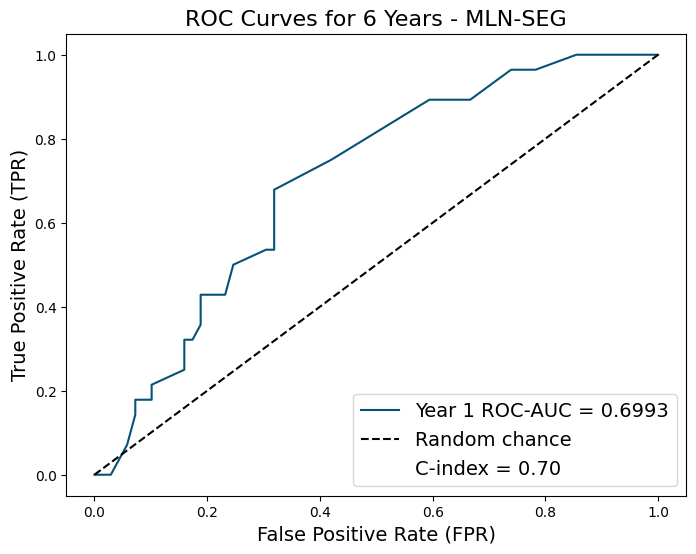

In [20]:
# Plotting
colors = ['#045275', '#089099', '#7CCBA2', '#FABF7B', '#E05C5C', '#AB1866']

plt.figure(figsize=(8, 6))

for year in range(1, 2):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = lndb_out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    auroc = mln_seg_out[f'{year}_year_auc']

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Year {year} ROC-AUC = {auroc:.4f}', color=colors[year-1])

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
plt.plot([], [], ' ', label=f"C-index = {lndb_out['c_index']:.2f}")

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curves for 6 Years - {dataset_name}', fontsize=16)
plt.legend(loc='lower right', fontsize=14)

# Show plot
plt.show()

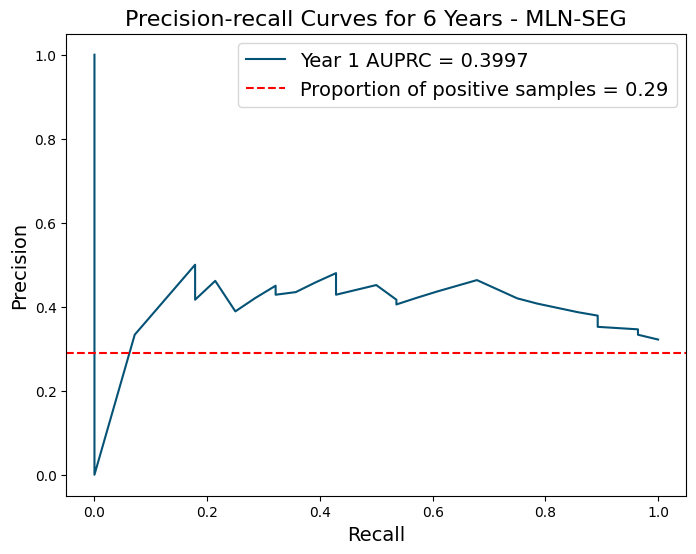

In [41]:
plt.figure(figsize=(8, 6))

for year in range(1, 2):
    pr_curve_data = lndb_out[f'{year}_year_pr_curve']
    precision = pr_curve_data['precision'] 
    recall = pr_curve_data['recall']
    pr_auc = mln_seg_out[f'{year}_year_prauc']

    # Plot precision-recall curve
    plt.plot(recall, precision, label=f'Year {year} AUPRC = {pr_auc:.4f}', color=colors[year-1])

# Plot horizontal line at 0.1515 to indicate the proportion of positive samples
plt.axhline(y=mln_seg_percent_positive, color='red', linestyle='--', 
            label=f'Proportion of positive samples = {mln_seg_percent_positive:.2f}')
# Set plot labels and title
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title(f'Precision-recall Curves for 6 Years - {dataset_name}', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

# Show plot
plt.show()

# Bootstrapping (AUROC, C-index, etc)
If this hasn't been calculated before, or you want to re-calculate the values, perform bootstrapping and save the results. 

In [23]:
# Parameters
n_bootstraps = 5000 
random_seed = 42 
np.random.seed(random_seed)

# Define where to save bootstrapping results 
bootstrap_result_path = '/workspace/home/tengyuezhang/sybil_cect/results/MLN-SEG/bootstrap_results_lndb.pkl'

In [24]:
auroc_scores_all_years = {f'year_{i}': [] for i in range(max_followup)} 
auprc_scores_all_years = {f'year_{i}': [] for i in range(max_followup)} 

# define args for c-index calculation 
args = Namespace(
    max_followup=max_followup, censoring_distribution=model._censoring_dist
)

# to store bootstrapped metrics 
bootstrapped_auroc = {f'year_{i+1}': [] for i in range(max_followup)}
bootstrapped_auprc = {f'year_{i+1}': [] for i in range(max_followup)}
bootstrapped_c_indices = [] 

# for i in range(n_bootstraps): 
for i in tqdm(range(n_bootstraps), desc="Bootstrapping", ncols=100):
    # resample data with replacement 
    bootstrap_indices = resample(range(len(df)), replace=True, n_samples=len(df))
    df_bootstrap = df.iloc[bootstrap_indices]
    pred_risk_scores_bootstrap = df_bootstrap[selected_columns].values.tolist()
    # event_times_bootstrap = df_bootstrap['years_to_event'].tolist() 
    event_times_bootstrap = [0] * len(df_bootstrap)
    event_observed_bootstrap = df_bootstrap['event'].tolist() 
    
    input_dict_bootstrap = {
        "probs": torch.tensor(pred_risk_scores_bootstrap), 
        "censors": torch.tensor(event_times_bootstrap), 
        "golds": torch.tensor(event_observed_bootstrap)
    }
    
    bootstrap_metrics = get_survival_metrics(input_dict_bootstrap, args)
    
    # print(bootstrap_metrics) 
    
    for year in range(1, max_followup+1): 
        bootstrapped_auroc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_auc'])
        bootstrapped_auprc[f'year_{year}'].append(bootstrap_metrics[f'{year}_year_prauc'])
    bootstrapped_c_indices.append(bootstrap_metrics['c_index'])
    

Bootstrapping: 100%|███████████████████████████████████████████| 5000/5000 [00:43<00:00, 116.23it/s]


In [25]:
import pickle 
bootstrap_results = {
    'bootstrapped_auroc': bootstrapped_auroc,  # AUROC
    'bootstrapped_c_indices': bootstrapped_c_indices,  # C-index
    'bootstrapped_auprc': bootstrapped_auprc, 
}
with open(bootstrap_result_path, 'wb') as f:
    pickle.dump(bootstrap_results, f)

In [26]:
# Load the dictionary from the pickle file
with open(bootstrap_result_path, 'rb') as f:
    loaded_results = pickle.load(f)

# Accessing the loaded data
bootstrapped_auroc = loaded_results['bootstrapped_auroc']
bootstrapped_c_indices = loaded_results['bootstrapped_c_indices']
bootstrapped_auprc = loaded_results['bootstrapped_auprc']

In [27]:
# 1) calculate mean AUROC and CIs for each year
auroc_results = {}
for year in range(1, max_followup+1):
    auroc_scores = bootstrapped_auroc[f'year_{year}']
    mean_auroc = np.mean(auroc_scores)
    lower_bound = np.percentile(auroc_scores, 2.5)
    upper_bound = np.percentile(auroc_scores, 97.5)
    auroc_results[f'year_{year}'] = {
        'mean_auroc': mean_auroc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUROC ========')
for year in range(1, max_followup+1): 
    year_auroc = auroc_results[f'year_{year}']['mean_auroc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auroc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')
    
# 2) calculate mean AUPRC and CIs for each year 
auprc_results = {}
for year in range(1, max_followup+1):
    auprc_scores = bootstrapped_auprc[f'year_{year}']
    mean_auprc = np.mean(auprc_scores)
    lower_bound = np.percentile(auprc_scores, 2.5)
    upper_bound = np.percentile(auprc_scores, 97.5)
    auprc_results[f'year_{year}'] = {
        'mean_auprc': mean_auprc,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

print('======== AUPRC ========')
for year in range(1, max_followup+1): 
    year_auprc = auprc_results[f'year_{year}']['mean_auprc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']
    print(f'Year {year} mean AUROC={year_auprc:.4f} (CI: [{year_lower:.2f}-{year_upper:.2f}])')

# 3) calculate mean C-index and CI
mean_c_index = np.mean(bootstrapped_c_indices)
c_index_lower_bound = np.percentile(bootstrapped_c_indices, 2.5)
c_index_upper_bound = np.percentile(bootstrapped_c_indices, 97.5)

print('======== C-index ========')
print(f'Mean AUROC={mean_c_index:.4f} (CI: [{c_index_lower_bound:.2f}-{c_index_upper_bound:.2f}])')

======== AUROC ========
Year 1 mean AUROC=0.6990 (CI: [0.59-0.80])
======== AUPRC ========
Year 1 mean AUROC=0.4110 (CI: [0.27-0.59])
======== C-index ========
Mean AUROC=0.6990 (CI: [0.59-0.80])


# Plot ROC curves and time-dependent AUROC with CI

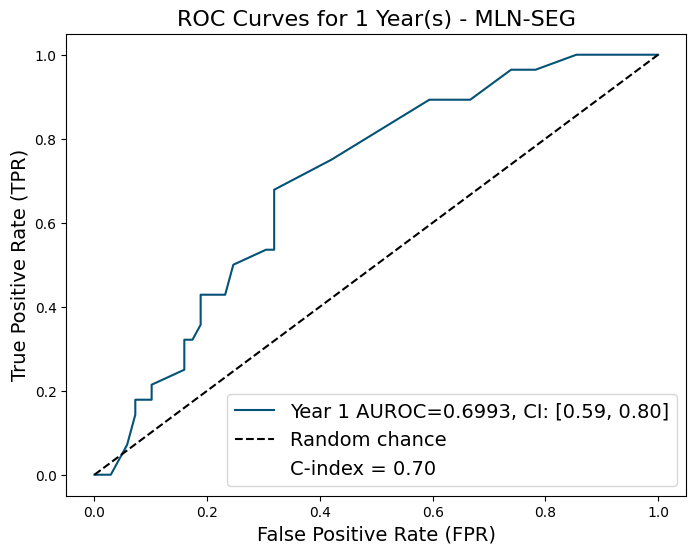

In [33]:
# Extract the C-index
c_index = mln_seg_out['c_index']

# Plotting
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    roc_curve_data = mln_seg_out[f'{year}_year_roc_curve']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    year_auroc = mln_seg_out[f'{year}_year_auc']
    year_lower = auroc_results[f'year_{year}']['lower_bound']
    year_upper = auroc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(fpr, tpr, 
            label=f'Year {year} AUROC={year_auroc:.4f}, CI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Plotting random chance
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')

# Include C-index in the legend
plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curves for {max_followup} Year(s) - {dataset_name}', fontsize=16)
plt.legend(loc='lower right', fontsize=14)

# Show plot
plt.show()

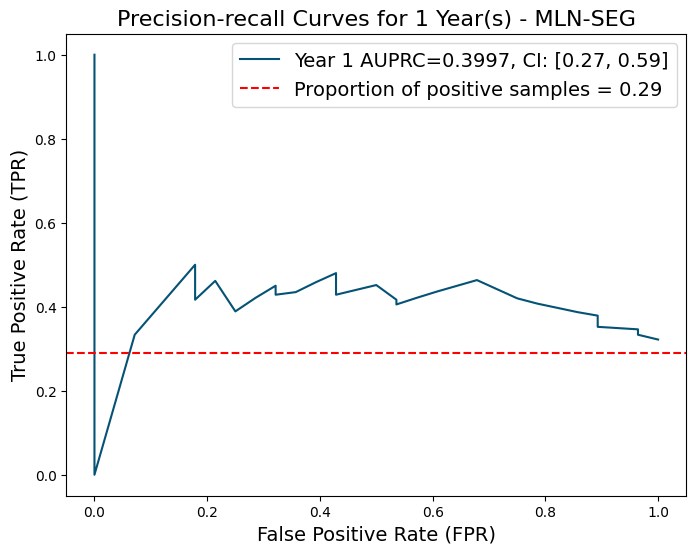

In [40]:
plt.figure(figsize=(8, 6))

for year in range(1, max_followup+1):
    # Extract FPR, TPR, and AUROC for the current year
    pr_curve_data = mln_seg_out[f'{year}_year_pr_curve']
    recall = pr_curve_data['recall']
    precision = pr_curve_data['precision']
    year_auprc = mln_seg_out[f'{year}_year_prauc']
    year_lower = auprc_results[f'year_{year}']['lower_bound']
    year_upper = auprc_results[f'year_{year}']['upper_bound']

    # Plot ROC curve
    plt.plot(recall, precision, 
            label=f'Year {year} AUPRC={year_auprc:.4f}, CI: [{year_lower:.2f}, {year_upper:.2f}]', 
             color=colors[year-1]
    )

# Include C-index in the legend
# plt.plot([], [], ' ', label=f'C-index = {c_index:.2f}')

# Plot horizontal line at 0.1515 to indicate the proportion of positive samples
plt.axhline(y=mln_seg_percent_positive, color='red', linestyle='--', 
            label=f'Proportion of positive samples = {mln_seg_percent_positive:.2f}')


# Set plot labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'Precision-recall Curves for {max_followup} Year(s) - {dataset_name}', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

# Show plot
plt.show()

# Select misclassified cases

In [24]:
RISK_CUTOFF=0.0121
df

,pid,Directory,Modality,Study Date,Contrast/Bolus Agent,Body Part Examined,Slice Thickness,Contrast/Bolus Route,Contrast/Bolus Ingredient,Requested Procedure Description,PrimaryCondition,event,time,pred_risk_year_0,pred_risk_year_1,pred_risk_year_2,pred_risk_year_3,pred_risk_year_4,pred_risk_year_5,y_0
0,case_0018,./Mediastinal-Lymph-Node-SEG/case_0018/07-26-2...,CT,07-26-2007,VOLUMEN & 100CC/ 2.5CC/SEC,CHEST,2.5,Oral & IV,NaN,NaN,Hodgkin`s Lymphoma,0,0,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.0
1,case_0023,./Mediastinal-Lymph-Node-SEG/case_0023/08-28-2...,CT,08-28-2013,isovue,CHEST,2.5,IV,NaN,NaN,Cholangiocarcinoma,0,0,0.131129,0.201569,0.219445,0.240922,0.258381,0.323277,0.0
2,case_0033,./Mediastinal-Lymph-Node-SEG/case_0033/10-14-2...,CT,10-14-2017,isovue,CHEST,2.5,IV,NaN,NaN,Lung Non-Small,1,0,0.117795,0.167839,0.189976,0.217799,0.229753,0.300137,1.0
3,case_0050,./Mediastinal-Lymph-Node-SEG/case_0050/02-03-2...,CT,02-03-2009,BARIUM & isovue,CHEST,2.5,Oral & IV,NaN,NaN,Head and Neck,0,0,0.131129,0.201569,0.207000,0.236478,0.248381,0.311559,0.0
4,case_0054,./Mediastinal-Lymph-Node-SEG/case_0054/06-02-2...,CT,06-02-2013,READICAT & 90CC/3.5CC/ISO,CHEST,2.5,Oral & IV,NaN,NaN,Thyroid,0,0,0.017994,0.029688,0.052035,0.069836,0.081818,0.125812,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,case_1084,./Mediastinal-Lymph-Node-SEG/case_1084/08-27-2...,CT,08-27-2008,READICAT & 120ML ISO,CHEST,2.5,Oral & IV,NaN,NaN,Lung Small,1,0,0.003951,0.015674,0.025835,0.035898,0.044462,0.065505,1.0
93,case_1091,./Mediastinal-Lymph-Node-SEG/case_1091/11-09-2...,CT,11-09-2008,SMOOTHIE & ISO370 90cc@2.5,CHEST,2.5,Oral & IV,NaN,NaN,GE Junction Adenocarcinoma,0,0,0.010938,0.023848,0.038154,0.051876,0.058135,0.092042,0.0
94,case_1093,./Mediastinal-Lymph-Node-SEG/case_1093/06-18-2...,CT,06-18-2012,REDICAT & ISOVUE 370,CHEST,2.5,Oral & IV,NaN,NaN,Colorectal,0,0,0.010901,0.020146,0.031846,0.041431,0.051451,0.076318,0.0
95,case_1092,./Mediastinal-Lymph-Node-SEG/case_1092/12-17-2...,CT,12-17-2010,Iopamidol (Isovue 370),CHEST,2.5,IV,NaN,NaN,Lung Small,1,0,0.255630,0.339926,0.354235,0.377972,0.403253,0.443316,1.0


In [25]:
df['Label'] = None

# TP: event == 1 and pred_risk_year_1 >= RISK_CUTOFF
df.loc[(df['event'] == 1) & (df['pred_risk_year_1'] >= RISK_CUTOFF), 'Label'] = 'TP'

# FP: event == 0 and pred_risk_year_1 >= RISK_CUTOFF
df.loc[(df['event'] == 0) & (df['pred_risk_year_1'] >= RISK_CUTOFF), 'Label'] = 'FP'

# FN: event == 1 and pred_risk_year_1 < RISK_CUTOFF
df.loc[(df['event'] == 1) & (df['pred_risk_year_1'] < RISK_CUTOFF), 'Label'] = 'FN'

# TN: event == 0 and pred_risk_year_1 < RISK_CUTOFF
df.loc[(df['event'] == 0) & (df['pred_risk_year_1'] < RISK_CUTOFF), 'Label'] = 'TN'

df

,pid,Directory,Modality,Study Date,Contrast/Bolus Agent,Body Part Examined,Slice Thickness,Contrast/Bolus Route,Contrast/Bolus Ingredient,Requested Procedure Description,...,event,time,pred_risk_year_0,pred_risk_year_1,pred_risk_year_2,pred_risk_year_3,pred_risk_year_4,pred_risk_year_5,y_0,Label
0,case_0018,./Mediastinal-Lymph-Node-SEG/case_0018/07-26-2...,CT,07-26-2007,VOLUMEN & 100CC/ 2.5CC/SEC,CHEST,2.5,Oral & IV,NaN,NaN,...,0,0,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.0,FP
1,case_0023,./Mediastinal-Lymph-Node-SEG/case_0023/08-28-2...,CT,08-28-2013,isovue,CHEST,2.5,IV,NaN,NaN,...,0,0,0.131129,0.201569,0.219445,0.240922,0.258381,0.323277,0.0,FP
2,case_0033,./Mediastinal-Lymph-Node-SEG/case_0033/10-14-2...,CT,10-14-2017,isovue,CHEST,2.5,IV,NaN,NaN,...,1,0,0.117795,0.167839,0.189976,0.217799,0.229753,0.300137,1.0,TP
3,case_0050,./Mediastinal-Lymph-Node-SEG/case_0050/02-03-2...,CT,02-03-2009,BARIUM & isovue,CHEST,2.5,Oral & IV,NaN,NaN,...,0,0,0.131129,0.201569,0.207000,0.236478,0.248381,0.311559,0.0,FP
4,case_0054,./Mediastinal-Lymph-Node-SEG/case_0054/06-02-2...,CT,06-02-2013,READICAT & 90CC/3.5CC/ISO,CHEST,2.5,Oral & IV,NaN,NaN,...,0,0,0.017994,0.029688,0.052035,0.069836,0.081818,0.125812,0.0,FP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,case_1084,./Mediastinal-Lymph-Node-SEG/case_1084/08-27-2...,CT,08-27-2008,READICAT & 120ML ISO,CHEST,2.5,Oral & IV,NaN,NaN,...,1,0,0.003951,0.015674,0.025835,0.035898,0.044462,0.065505,1.0,TP
93,case_1091,./Mediastinal-Lymph-Node-SEG/case_1091/11-09-2...,CT,11-09-2008,SMOOTHIE & ISO370 90cc@2.5,CHEST,2.5,Oral & IV,NaN,NaN,...,0,0,0.010938,0.023848,0.038154,0.051876,0.058135,0.092042,0.0,FP
94,case_1093,./Mediastinal-Lymph-Node-SEG/case_1093/06-18-2...,CT,06-18-2012,REDICAT & ISOVUE 370,CHEST,2.5,Oral & IV,NaN,NaN,...,0,0,0.010901,0.020146,0.031846,0.041431,0.051451,0.076318,0.0,FP
95,case_1092,./Mediastinal-Lymph-Node-SEG/case_1092/12-17-2...,CT,12-17-2010,Iopamidol (Isovue 370),CHEST,2.5,IV,NaN,NaN,...,1,0,0.255630,0.339926,0.354235,0.377972,0.403253,0.443316,1.0,TP


In [26]:
label_counts = df['Label'].value_counts()

# Get individual counts for TP, FP, FN, TN
tp_count = label_counts.get('TP', 0)
fp_count = label_counts.get('FP', 0)
fn_count = label_counts.get('FN', 0)
tn_count = label_counts.get('TN', 0)

# Print the counts
print(f"True Positives (TP): {tp_count}")
print(f"False Positives (FP): {fp_count}")
print(f"False Negatives (FN): {fn_count}")
print(f"True Negatives (TN): {tn_count}")

True Positives (TP): 26
False Positives (FP): 50
False Negatives (FN): 2
True Negatives (TN): 19


save sorted images

In [28]:
# create output folders 

result_root_dir = '/workspace/home/tengyuezhang/sybil_cect/visualizations/MLN_SEG/MLN_SEG_sorted_attention_maps'
if not os.path.exists(result_root_dir):
    os.makedirs(result_root_dir)

subfolders = ['FP', 'TP', 'TN', 'FN']
for folder in subfolders: 
    subfolder_path = os.path.join(result_root_dir, folder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)


In [39]:
import shutil 
def copy_folders_from_df(df, label, input_root_dir, output_dir):
#     print(df['pid'])
    for index, row in df.iterrows(): 
        pid = row['pid']
        
        # construct the source folder path 
        source_folder = os.path.abspath(os.path.join(input_root_dir, pid))
        # construct the destination folder 
        dest_folder = os.path.abspath(os.path.join(output_dir, row['Label'], pid))
        shutil.copytree(source_folder, dest_folder)
#         if label in ['FP', 'TP', 'TN', 'FN']: 
#             dest_folder = os.path.join(output_dir, label, pid)
#             print(dest_folder)
#             # check if the destination folder already exists 
#             if not os.path.exists(dest_folder): 
#                 # check if the source folder exists
#                 if os.path.exists(source_folder): 
# #                     shutil.copytree(source_folder, dest_folder)
#                     pass
#                 else: 
#                     print(f"Source folder {source_folder} does not exist.")
#             else: print(f"Destination folder {dest_folder} already exist. Skipping...")
            

In [40]:
vis_dir_path = "/workspace/home/tengyuezhang/sybil_cect/visualizations/MLN_SEG_attention_maps"
for label in ['FP', 'TP', 'TN', 'FN']: 
    copy_folders_from_df(df, label, vis_dir_path, result_root_dir)

FileExistsError: [Errno 17] File exists: '/workspace/home/tengyuezhang/sybil_cect/visualizations/MLN_SEG/MLN_SEG_sorted_attention_maps/FP/case_0018'